In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
import datetime
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix

In [2]:
from mochi import f_beta_01,runLGBM,check_feature_importance

In [3]:
class Config:
    pass
config = pd.read_pickle('config.pkl')
data_path = config.data_path
feature_path = config.feature_path
print(dir(config))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'data_path', 'feature_dict', 'feature_path', 'model_features', 'result_path', 'single_module_validation_indice_set', 'trade_train_size', 'train_2_6_index']


In [4]:
config.feature_dict.keys()

dict_keys(['trade_and_recent_login_comparing', 'recent_login_detail', 'trade_detail_feature', 'login_trade_hist_stats', 'llc_user_habbit', 'hcc_user_habbit', 'hcc_properties', 'hcc_target_encoding', 'login_detail_new_features', 'hcc_mult_target_encoding', 'hcc_user_trade_habbit', 'hcc_trade_properties'])

New features sets are: 

- login_detail_new_features
- hcc_user_trade_habbit
- hcc_trade_properties
- hcc_mult_target_encoding


In [6]:
#basic setting up for the validation
validation_tuple_list = config.single_module_validation_indice_set
train_labels = pd.read_pickle(data_path+'trade_train_label.pkl')

# Baseline

###  picking up features

In [5]:
features =   (config.feature_dict['trade_detail_feature']+
              config.feature_dict['recent_login_detail']+
              config.feature_dict['trade_and_recent_login_comparing']+
              config.feature_dict['login_trade_hist_stats']+
              config.feature_dict['llc_user_habbit']+
              config.feature_dict['hcc_user_habbit']+
              config.feature_dict['hcc_properties']+
              config.feature_dict['hcc_target_encoding']
             )
feature_sequence_list = []
for feature in features:
    feature_sequence_list.append(pd.read_pickle(feature_path+feature+'.pkl').reshape(-1,1))
    
trade_tt_mat = np.hstack(feature_sequence_list)

### Validation

In [7]:
cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_mat[train_indice], trade_tt_mat[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.990758	test's auc: 0.975527
[200]	train's auc: 0.995201	test's auc: 0.988838
[300]	train's auc: 0.998843	test's auc: 0.989149
Early stopping, best iteration is:
[269]	train's auc: 0.997887	test's auc: 0.989682
f_beta score for the turn 1 is 0.891881450411
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.992749	test's auc: 0.965291
[200]	train's auc: 0.99762	test's auc: 0.975059
Early stopping, best iteration is:
[196]	train's auc: 0.99746	test's auc: 0.975222
f_beta score for the turn 2 is 0.877624909486
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.992695	test's auc: 0.980162
[200]	train's auc: 0.99746	test's auc: 0.984728
Early stopping, best iteration is:
[185]	train's auc: 0.997105	test's auc: 0.985247
f_beta score for the turn 3 is 0.888882889693
Training until validation scores don't improve for 100 rounds.
[100]	train's auc:

# checking the new details

In [8]:
config.feature_dict['login_detail_new_features']

['login_distance_0_al',
 'login_distance_1_al',
 'login_distance_2_al',
 'mean_login_distance',
 'timelong_login_0_mod_1000',
 'timelong_login_1_mod_1000',
 'timelong_login_2_mod_1000',
 'login_distance_diff']

In [26]:
features =   (config.feature_dict['trade_detail_feature']+
              config.feature_dict['recent_login_detail']+
              config.feature_dict['trade_and_recent_login_comparing']+
              config.feature_dict['login_trade_hist_stats']+
              config.feature_dict['llc_user_habbit']+
              config.feature_dict['hcc_user_habbit']+
              config.feature_dict['hcc_properties']+
              config.feature_dict['hcc_target_encoding']+
              config.feature_dict['login_detail_new_features']
             )
#features.remove('login_distance_0')
#features.remove('login_distance_1')
#features.remove('login_distance_2')

feature_sequence_list = []
for feature in features:
    feature_sequence_list.append(pd.read_pickle(feature_path+feature+'.pkl').reshape(-1,1))
    
trade_tt_mat = np.hstack(feature_sequence_list)

In [27]:
cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_mat[train_indice], trade_tt_mat[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.990953	test's auc: 0.977403
[200]	train's auc: 0.995442	test's auc: 0.989479
[300]	train's auc: 0.999271	test's auc: 0.990109
Early stopping, best iteration is:
[275]	train's auc: 0.998308	test's auc: 0.990536
f_beta score for the turn 1 is 0.895560918121
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.993413	test's auc: 0.966461
[200]	train's auc: 0.99822	test's auc: 0.975249
[300]	train's auc: 0.999775	test's auc: 0.974502
Early stopping, best iteration is:
[219]	train's auc: 0.998362	test's auc: 0.97616
f_beta score for the turn 2 is 0.875679647318
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994396	test's auc: 0.983831
[200]	train's auc: 0.998508	test's auc: 0.986448
Early stopping, best iteration is:
[171]	train's auc: 0.997905	test's auc: 0.986682
f_beta score for the turn 3 is 0.884109338918
Training until validation score

In [28]:
sorted_feature_importacne = check_feature_importance(models,features)
sorted_feature_importacne

[('ip_t_encoding', 173455.34950549519),
 ('id_t_encoding', 95968.011225531081),
 ('device_t_encoding', 29109.183702396451),
 ('login_distance_0_al', 10421.503406263579),
 ('login_distance_0', 9843.5013785526316),
 ('trade_times_360', 8201.7541468896397),
 ('city_t_encoding', 5869.3835492831813),
 ('mean_login_distance', 5490.4504330461541),
 ('device_repeat_count_360', 4486.4586597959615),
 ('type_3_count_30', 4064.6316964920088),
 ('login_success_rate_360', 3945.4083606679269),
 ('period_4_login_rate_30', 3775.0305233514182),
 ('timelong_std_1', 3348.958367957574),
 ('period_4_login_rate_360', 3136.7895360176822),
 ('timelong_max_1', 2897.4711197108936),
 ('type_login_0', 2826.190786760757),
 ('login_distance_1_al', 2429.7490088676986),
 ('period_3_login_rate_360', 2421.1800716230964),
 ('timelong_std_3', 2409.2377208241742),
 ('type_3_rate_30', 2231.4492379873732),
 ('success_1_rate_30', 1956.9827703671754),
 ('timelong_min_30', 1945.3399037557479),
 ('login_distance_1', 1923.0049927

<Container object of 375 artists>

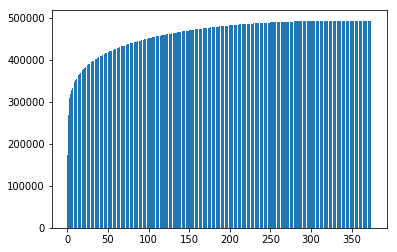

In [29]:
%matplotlib inline
all_importance = [x[1] for x in sorted_feature_importacne]
x = pd.Series(all_importance).sort_values(ascending = False).cumsum()
plt.bar(range(len(x)),x)

In [30]:
#truncate at about 300
top_features =  [x[0] for x in sorted_feature_importacne][0:275]
top_features_ori_index = [features.index(x) for x in top_features]
trade_tt_top = trade_tt_mat[:,top_features_ori_index]

In [31]:
#top features
cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_top[train_indice], trade_tt_top[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=top_features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.991194	test's auc: 0.978761
[200]	train's auc: 0.995929	test's auc: 0.989291
[300]	train's auc: 0.999355	test's auc: 0.989242
Early stopping, best iteration is:
[237]	train's auc: 0.996663	test's auc: 0.990085
f_beta score for the turn 1 is 0.896831122704
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.992608	test's auc: 0.968501
[200]	train's auc: 0.99809	test's auc: 0.97468
Early stopping, best iteration is:
[194]	train's auc: 0.997913	test's auc: 0.975743
f_beta score for the turn 2 is 0.873676360925
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994401	test's auc: 0.984466
[200]	train's auc: 0.99833	test's auc: 0.986829
[300]	train's auc: 0.999595	test's auc: 0.985947
Early stopping, best iteration is:
[200]	train's auc: 0.99833	test's auc: 0.986829
f_beta score for the turn 3 is 0.873991773944
Training until validation scores 

### try using without the old login_distance

In [12]:
features.remove('login_distance_0')
features.remove('login_distance_1')
features.remove('login_distance_2')

feature_sequence_list = []
for feature in features:
    feature_sequence_list.append(pd.read_pickle(feature_path+feature+'.pkl').reshape(-1,1))
    
trade_tt_mat = np.hstack(feature_sequence_list)


In [13]:
cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_mat[train_indice], trade_tt_mat[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.990692	test's auc: 0.981366
[200]	train's auc: 0.995031	test's auc: 0.989398
[300]	train's auc: 0.999413	test's auc: 0.990162
Early stopping, best iteration is:
[272]	train's auc: 0.998551	test's auc: 0.990499
f_beta score for the turn 1 is 0.890563089458
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.993084	test's auc: 0.968591
[200]	train's auc: 0.998169	test's auc: 0.975974
Early stopping, best iteration is:
[195]	train's auc: 0.998011	test's auc: 0.976649
f_beta score for the turn 2 is 0.886903860712
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994425	test's auc: 0.984343
[200]	train's auc: 0.998575	test's auc: 0.986628
[300]	train's auc: 0.999633	test's auc: 0.987134
[400]	train's auc: 0.999924	test's auc: 0.988516
[500]	train's auc: 0.999989	test's auc: 0.988619
Early stopping, best iteration is:
[406]	train's auc: 0.99993

# checking hcc_mult_target_encoding

In [14]:
features =   (config.feature_dict['trade_detail_feature']+
              config.feature_dict['recent_login_detail']+
              config.feature_dict['trade_and_recent_login_comparing']+
              config.feature_dict['login_trade_hist_stats']+
              config.feature_dict['llc_user_habbit']+
              config.feature_dict['hcc_user_habbit']+
              config.feature_dict['hcc_properties']+
              config.feature_dict['hcc_target_encoding']+
              config.feature_dict['login_detail_new_features']+
              config.feature_dict['hcc_mult_target_encoding']
             )

feature_sequence_list = []
for feature in features:
    feature_sequence_list.append(pd.read_pickle(feature_path+feature+'.pkl').reshape(-1,1))
    
trade_tt_mat = np.hstack(feature_sequence_list)

cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_mat[train_indice], trade_tt_mat[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.99057	test's auc: 0.977863
[200]	train's auc: 0.994942	test's auc: 0.990187
[300]	train's auc: 0.999403	test's auc: 0.989845
Early stopping, best iteration is:
[271]	train's auc: 0.998687	test's auc: 0.990592
f_beta score for the turn 1 is 0.903617103024
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.993332	test's auc: 0.972069
[200]	train's auc: 0.99834	test's auc: 0.975197
Early stopping, best iteration is:
[177]	train's auc: 0.99783	test's auc: 0.975886
f_beta score for the turn 2 is 0.862997827661
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994617	test's auc: 0.984525
[200]	train's auc: 0.998555	test's auc: 0.986516
Early stopping, best iteration is:
[160]	train's auc: 0.997346	test's auc: 0.986578
f_beta score for the turn 3 is 0.876535123629
Training until validation scores don't improve for 100 rounds.
[100]	train's auc:

In [15]:
sorted_feature_importacne = check_feature_importance(models,features)
sorted_feature_importacne

[('ip_t_encoding', 169464.49544331498),
 ('id_t_encoding', 41646.474102186454),
 ('city_id_t_encoding', 29072.607962841957),
 ('ip_id_t_encoding', 25308.678166470774),
 ('device_t_encoding', 17624.054212282888),
 ('login_distance_0_al', 9489.5345825527475),
 ('device_id_t_encoding', 8608.4477851320044),
 ('login_distance_0', 7869.7446011401544),
 ('trade_times_360', 6917.8616554723112),
 ('city_t_encoding', 4291.6039511102745),
 ('mean_login_distance', 3985.2639607445617),
 ('device_repeat_count_360', 3805.4701151788045),
 ('type_3_count_30', 3595.1308508874044),
 ('login_success_rate_360', 3279.8868909915468),
 ('period_4_login_rate_30', 3265.7406632287948),
 ('type_3_rate_30', 2862.9036132582519),
 ('timelong_std_1', 2743.0278262245051),
 ('timelong_max_1', 2672.6967598804245),
 ('period_4_login_rate_360', 2633.2135220525579),
 ('timelong_min_30', 2144.8445153945913),
 ('login_success_rate_30', 2126.636788689656),
 ('timelong_std_3', 2111.5487171884106),
 ('type_login_0', 2062.393603

# checking hcc_trade_properties

In [16]:
features =   (config.feature_dict['trade_detail_feature']+
              config.feature_dict['recent_login_detail']+
              config.feature_dict['trade_and_recent_login_comparing']+
              config.feature_dict['login_trade_hist_stats']+
              config.feature_dict['llc_user_habbit']+
              config.feature_dict['hcc_user_habbit']+
              config.feature_dict['hcc_properties']+
              config.feature_dict['hcc_target_encoding']+
              config.feature_dict['login_detail_new_features']+
              config.feature_dict['hcc_trade_properties']
             )

feature_sequence_list = []
for feature in features:
    feature_sequence_list.append(pd.read_pickle(feature_path+feature+'.pkl').reshape(-1,1))
    
trade_tt_mat = np.hstack(feature_sequence_list)

cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_mat[train_indice], trade_tt_mat[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.99158	test's auc: 0.983486
[200]	train's auc: 0.9949	test's auc: 0.989563
[300]	train's auc: 0.999389	test's auc: 0.989424
Early stopping, best iteration is:
[275]	train's auc: 0.998609	test's auc: 0.990319
f_beta score for the turn 1 is 0.892529776607
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.992866	test's auc: 0.965535
[200]	train's auc: 0.998184	test's auc: 0.973163
Early stopping, best iteration is:
[183]	train's auc: 0.997864	test's auc: 0.974398
f_beta score for the turn 2 is 0.875679647318
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994863	test's auc: 0.985162
[200]	train's auc: 0.998684	test's auc: 0.986611
Early stopping, best iteration is:
[146]	train's auc: 0.996292	test's auc: 0.986859
f_beta score for the turn 3 is 0.882742522121
Training until validation scores don't improve for 100 rounds.
[100]	train's auc:

In [17]:
sorted_feature_importacne = check_feature_importance(models,features)
sorted_feature_importacne

[('ip_t_encoding', 166437.82932768174),
 ('id_t_encoding', 98250.36333798914),
 ('device_t_encoding', 33494.746390911452),
 ('login_distance_0', 10817.423799885597),
 ('login_distance_0_al', 9959.6604065490683),
 ('trade_times_360', 8743.8651948217885),
 ('city_t_encoding', 6479.0682789392986),
 ('mean_login_distance', 5875.2497074790135),
 ('type_3_count_30', 4137.7970305395829),
 ('period_4_login_rate_30', 4105.5156268061864),
 ('login_success_rate_360', 3691.9153486200494),
 ('device_repeat_count_360', 3199.1661469846581),
 ('timelong_std_1', 3076.4479530579451),
 ('period_4_login_rate_360', 3038.9274279690862),
 ('type_3_rate_30', 2817.2545702029447),
 ('period_3_login_rate_360', 2668.8470137123709),
 ('timelong_max_1', 2622.4370585707939),
 ('login_distance_1_al', 2558.2258769016089),
 ('timelong_std_3', 2399.7331308193093),
 ('type_login_0', 2388.912280863311),
 ('timelong_min_30', 2266.5195407117526),
 ('success_1_rate_30', 2239.5983457335406),
 ('login_distance_1', 2050.8387309

# checking hcc_user_trade_habbit

In [19]:
features =   (config.feature_dict['trade_detail_feature']+
              config.feature_dict['recent_login_detail']+
              config.feature_dict['trade_and_recent_login_comparing']+
              config.feature_dict['login_trade_hist_stats']+
              config.feature_dict['llc_user_habbit']+
              config.feature_dict['hcc_user_habbit']+
              config.feature_dict['hcc_properties']+
              config.feature_dict['hcc_target_encoding']+
              config.feature_dict['login_detail_new_features']+
              config.feature_dict['hcc_trade_properties']
             )

feature_sequence_list = []
for feature in features:
    feature_sequence_list.append(pd.read_pickle(feature_path+feature+'.pkl').reshape(-1,1))
    
trade_tt_mat = np.hstack(feature_sequence_list)

cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_mat[train_indice], trade_tt_mat[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.


KeyboardInterrupt: 

# adding all new features

In [32]:
features =   (config.feature_dict['trade_detail_feature']+
              config.feature_dict['recent_login_detail']+
              config.feature_dict['trade_and_recent_login_comparing']+
              config.feature_dict['login_trade_hist_stats']+
              config.feature_dict['llc_user_habbit']+
              config.feature_dict['hcc_user_habbit']+
              config.feature_dict['hcc_properties']+
              config.feature_dict['hcc_target_encoding']+
              config.feature_dict['login_detail_new_features']+
              config.feature_dict['hcc_trade_properties']+
              config.feature_dict['hcc_mult_target_encoding']+
              config.feature_dict['hcc_user_trade_habbit']
             )

feature_sequence_list = []
for feature in features:
    feature_sequence_list.append(pd.read_pickle(feature_path+feature+'.pkl').reshape(-1,1))
    
trade_tt_mat = np.hstack(feature_sequence_list)

cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_mat[train_indice], trade_tt_mat[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.990763	test's auc: 0.979595
[200]	train's auc: 0.995056	test's auc: 0.990177
[300]	train's auc: 0.999344	test's auc: 0.991104
Early stopping, best iteration is:
[274]	train's auc: 0.998728	test's auc: 0.991667
f_beta score for the turn 1 is 0.899994324309
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.99275	test's auc: 0.970425
[200]	train's auc: 0.998344	test's auc: 0.974486
Early stopping, best iteration is:
[195]	train's auc: 0.998266	test's auc: 0.975684
f_beta score for the turn 2 is 0.873676360925
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.99456	test's auc: 0.983769
[200]	train's auc: 0.998631	test's auc: 0.987013
Early stopping, best iteration is:
[184]	train's auc: 0.998297	test's auc: 0.9871
f_beta score for the turn 3 is 0.891783014182
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 

In [33]:
sorted_feature_importacne = check_feature_importance(models,features)
sorted_feature_importacne

[('ip_t_encoding', 156494.80105254505),
 ('id_t_encoding', 48381.936827580968),
 ('city_id_t_encoding', 33202.499643492381),
 ('ip_id_t_encoding', 33198.356563503723),
 ('device_t_encoding', 13982.622251599452),
 ('login_distance_0_al', 11522.613522728494),
 ('device_id_t_encoding', 11167.864608543234),
 ('login_distance_0', 8609.7433330774129),
 ('trade_times_360', 7745.5432295303399),
 ('city_t_encoding', 5601.6159767547306),
 ('mean_login_distance', 4925.0597129267644),
 ('type_3_count_30', 4235.4638908406168),
 ('period_4_login_rate_30', 4213.9580206021255),
 ('login_success_rate_360', 3588.0558841381253),
 ('device_repeat_count_360', 3242.1977514670298),
 ('timelong_std_1', 3153.148993883442),
 ('period_4_login_rate_360', 2881.6288452316858),
 ('timelong_max_1', 2757.5360867745449),
 ('type_login_0', 2700.8256339669606),
 ('type_3_rate_30', 2546.0255710452211),
 ('period_3_login_rate_360', 2531.4583948663044),
 ('login_distance_1_al', 2373.3727904111593),
 ('timelong_std_3', 2245.

<Container object of 446 artists>

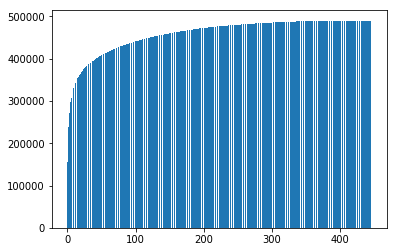

In [34]:
%matplotlib inline
all_importance = [x[1] for x in sorted_feature_importacne]
x = pd.Series(all_importance).sort_values(ascending = False).cumsum()
plt.bar(range(len(x)),x)

In [35]:
#truncate at about 300
top_features =  [x[0] for x in sorted_feature_importacne][0:300]
top_features_ori_index = [features.index(x) for x in top_features]
trade_tt_top = trade_tt_mat[:,top_features_ori_index]

In [37]:
dir(config)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'data_path',
 'feature_dict',
 'feature_path',
 'model_features',
 'result_path',
 'single_module_validation_indice_set',
 'trade_train_size',
 'train_2_6_index']

In [38]:
config.model_features['model_I_top300'] = top_features
pd.to_pickle(config,'config.pkl')

In [25]:
#top features
cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_top[train_indice], trade_tt_top[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=top_features,verbose=100,eta=0.02,
                          early_stop=100,num_rounds=3500,watch_dict=result_dict,feval = None)

    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.5, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.991564	test's auc: 0.980625
[200]	train's auc: 0.995187	test's auc: 0.990065
[300]	train's auc: 0.999296	test's auc: 0.990508
Early stopping, best iteration is:
[275]	train's auc: 0.998555	test's auc: 0.991351
f_beta score for the turn 1 is 0.897455709476
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.992231	test's auc: 0.967445
[200]	train's auc: 0.99838	test's auc: 0.977005
[300]	train's auc: 0.999797	test's auc: 0.974224
Early stopping, best iteration is:
[201]	train's auc: 0.99839	test's auc: 0.977113
f_beta score for the turn 2 is 0.862997827661
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.994189	test's auc: 0.983364
[200]	train's auc: 0.998678	test's auc: 0.986676
[300]	train's auc: 0.999645	test's auc: 0.986835
[400]	train's auc: 0.999928	test's auc: 0.988034
[500]	train's auc: 0.999988	test's auc: 0.987847
Early stopping